<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# ForestDML and ForestDRLearner: Basic Example

We depict the performance of our `ForestDMLCateEstimator` and `ForestDRLearner` estimator on the same data generating process as the one used in the tutorial page of the grf package (see https://github.com/grf-labs/grf#usage-examples). This is mostly for qualitative comparison and verification purposes among our implementation of variants of Causal Forests and the implementation in the grf R package.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# DGP

We use the following data generating process (DGP) from [here](https://github.com/grf-labs/grf#usage-examples):

\begin{align}
X \sim& \text{Normal}(0,\, I_{p})\\
T =& \text{Binomial}(1, .4 + .2 \cdot 1\{X[0] > 0\})\\
Y =& (X[0] \cdot 1\{X[0] > 0\}) \cdot T + X[1] + X[2] \cdot 1\{X[2] < 0\} + \epsilon, &\; \epsilon \sim \text{Normal}(0, 1)\\
\end{align}

We use $p=10$ and draw $n=2000$ samples from this DGP.

In [4]:
import numpy as np
import scipy.special
np.random.seed(123)
n = 2000
p = 10
X = np.random.normal(size=(n, p))
true_propensity = lambda x: .4 + .2 * (x[:, 0] > 0)
true_effect = lambda x: (x[:, 0] * (x[:, 0] > 0))
true_conf = lambda x: x[:, 1] + np.clip(x[:, 2], - np.inf, 0)
T = np.random.binomial(1, true_propensity(X))
Y =  true_effect(X) * T + true_conf(X) + np.random.normal(size=(n,))

### Cross-Validated Forest Nuisance Models

We use forest based estimators (Gradient Boosted Forests or Random Forests) as nuisance models. For the meta-learner versions of our forest based estimators, we also use a generic forest estimator even as a final model. The hyperparameters of the forest models (e.g. number of estimators, max depth, min leaf size) is chosen via cross validation. We also choose among Gradient or Random Forests via cross validation

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

class GridSearchCVList:

    def __init__(self, estimator_list, param_grid_list, scoring=None,
                 n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs',
                 error_score='raise-deprecating', return_train_score=False):
        self._gcv_list = [GridSearchCV(estimator, param_grid, scoring=scoring,
                                       n_jobs=n_jobs, iid=iid, refit=refit, cv=cv, verbose=verbose,
                                       pre_dispatch=pre_dispatch, error_score=error_score,
                                       return_train_score=return_train_score)
                          for estimator, param_grid in zip(estimator_list, param_grid_list)]
        return

    def fit(self, X, y, **fit_params):
        self.best_ind_ = np.argmax([gcv.fit(X, y, **fit_params).best_score_ for gcv in self._gcv_list])
        self.best_estimator_ = self._gcv_list[self.best_ind_].best_estimator_
        self.best_score_ = self._gcv_list[self.best_ind_].best_score_
        self.best_params_ = self._gcv_list[self.best_ind_].best_params_
        return self

    def predict(self, X):
        return self.best_estimator_.predict(X)

    def predict_proba(self, X):
        return self.best_estimator_.predict_proba(X)

from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from econml.sklearn_extensions.linear_model import WeightedLassoCV

def first_stage_reg():
    return GridSearchCVList([RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=3,
                             iid=True)

def first_stage_clf():
    return GridSearchCVList([RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=3,
                             iid=True)

def final_stage():
    return GridSearchCVList([RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=3,
                             iid=True)

# DML Estimators

In [6]:
from econml.dml import ForestDMLCateEstimator
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDMLCateEstimator(model_y=first_stage_reg(),
                             model_t=first_stage_clf(),
                             discrete_treatment=True,
                             n_crossfit_splits=3,
                             n_estimators=4000,
                             subsample_fr='auto',
                             min_samples_leaf=5,
                             verbose=0,
                             min_weight_fraction_leaf=.001)
est.fit(Y, T, X, inference='blb')

In [7]:
from econml.dml import NonParamDMLCateEstimator
est2 = NonParamDMLCateEstimator(model_y=first_stage_reg(),
                                model_t=first_stage_clf(),
                                n_splits=3,
                                discrete_treatment=True,
                                model_final=final_stage())
est2.fit(Y, T, X)

In [8]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [9]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [10]:
pred2 = est2.effect(X_test)

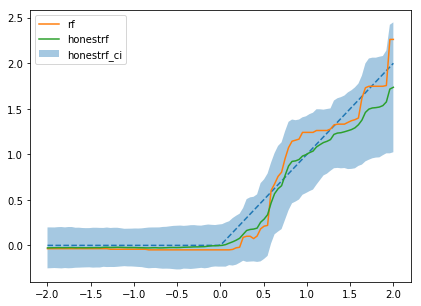

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred2, label='rf')
plt.plot(X_test[:, 0], pred, label='honestrf')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='honestrf_ci')
plt.legend()
plt.show()

### First Stage Learned Models

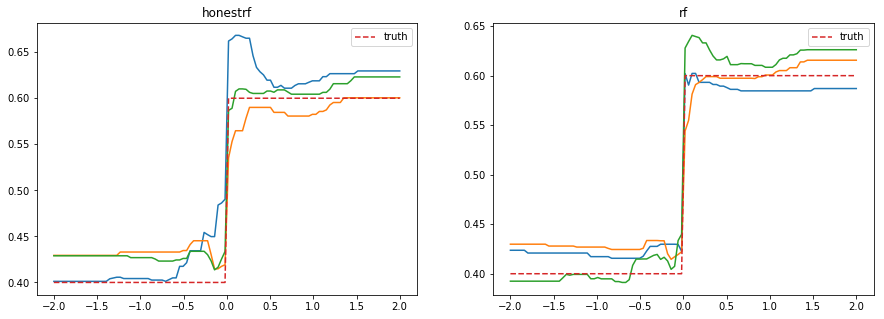

In [12]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_t:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_t:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()
plt.show()

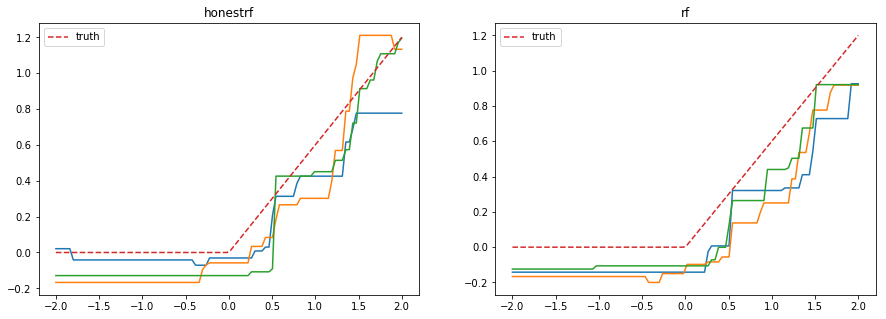

In [13]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_y:
    plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(X_test[:, 0], true_effect(X_test) * true_propensity(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_y:
    plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(X_test[:, 0], true_effect(X_test) * true_propensity(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()
plt.show()

### Interpretability of CATE Model of NonParamDMLCateEstimator with SHAP

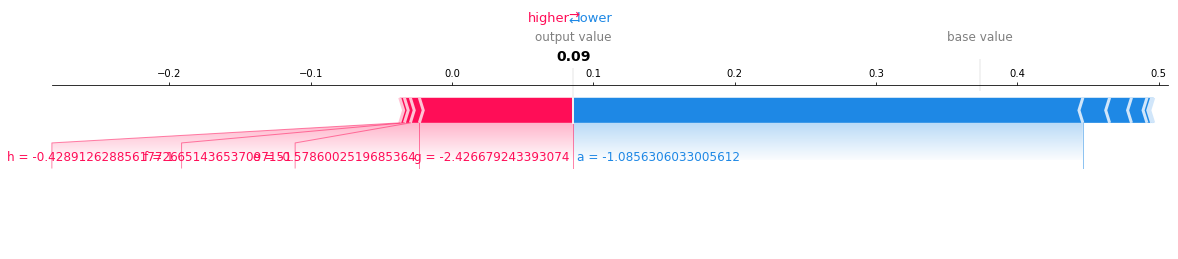

In [15]:
import shap
import pandas as pd
import string
Xdf = pd.DataFrame(X, columns=list(string.ascii_lowercase)[:X.shape[1]])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(est2.model_cate.best_estimator_)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

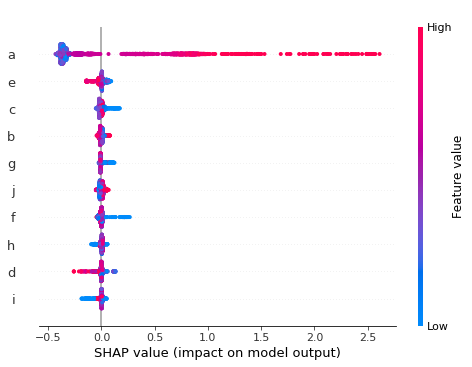

In [16]:
shap.summary_plot(shap_values, Xdf)

# DRLearner

In [ ]:
from econml.drlearner import ForestDRLearner
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDRLearner(model_regression=first_stage_reg(),
                      model_propensity=first_stage_clf(),
                      n_crossfit_splits=3,
                      n_estimators=4000,
                      subsample_fr='auto',
                      min_samples_leaf=5,
                      verbose=0,
                      min_weight_fraction_leaf=.001)
est.fit(Y, T, X, inference='blb')

In [ ]:
from econml.drlearner import DRLearner
est2 = DRLearner(model_regression=first_stage_reg(),
                 model_propensity=first_stage_clf(),
                 model_final=final_stage(),
                 n_splits=3)
est2.fit(Y, T, X)

In [ ]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [ ]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [ ]:
pred2 = est2.effect(X_test)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred2, label='rf')
plt.plot(X_test[:, 0], pred, label='honestrf')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='honestrf_ci')
plt.legend()
plt.show()

### First stage nuisance models

In [ ]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_propensity:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_propensity:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()
plt.show()

In [ ]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_regression:
    plt.plot(X_test[:, 0], mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])))
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_regression:
    plt.plot(X_test[:, 0], mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])))
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()
plt.show()

### Interpretability of CATE Model of DRLearner with SHAP

In [ ]:
import shap
import pandas as pd
import string
Xdf = pd.DataFrame(X, columns=list(string.ascii_lowercase)[:X.shape[1]])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(est2.model_cate().best_estimator_)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values, Xdf)